# Medoid Radius

Medoid Radius is a cluster algorithm that I use in one of my projects. I did not find not cluster algorithm suitable for my case such that I proposed this novel algorithm.

My case is like that, each data point is a shape, I managed to find a way to measure the distance matrix for the shapes. Another requirement is that we only cluster data points that are very similar together. Data points without a near neighbor are discarded.


## Example
Suppose we have the following RNA sequences.

![](medoid_radius/rna_123.jpg)
![](medoid_radius/rna_456.jpg)

We number them from 0 to 5, and the distance matrix is as follow:



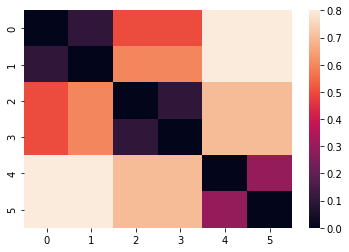

In [25]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

D=np.array([
    [0.0, 0.1, 0.5, 0.5, 0.8, 0.8],
    [0.1, 0.0, 0.6, 0.6, 0.8, 0.8],
    [0.5, 0.6, 0.0, 0.1, 0.7, 0.7],
    [0.5, 0.6, 0.1, 0.0, 0.7, 0.7],
    [0.8, 0.8, 0.7, 0.7, 0.0, 0.3],
    [0.8, 0.8, 0.7, 0.7, 0.3, 0.0]])

sns.heatmap(D)
plt.show()

Here, we have two clusters, (0, 1) and (2, 3). 4 and 5 are not similar enough that they can be grouped together, neither are they similar to the rest RNAs. Thus, 4 and 5 are to be discarded.

Steps:

Input: Distance Matrix $D$, radius $r$

Step 1: Find the largest cluster $C$, with points $(k, l, ...)$. If no cluster is found, quit.
  * Scan every row $i$ in $D$, Select a row $i$ with the most satisfied data points($d_{ij}<r$)
  * $d_{ij}$ denotes distance between Data Point $i$ and $j$
  
$$
\underset {i}{\operatorname{argmax}} \sum_{j=0}^{n} (d_{ij}<r), (d_{ij}<r\ =\ 1\ if\ true, 0\ if\ false)
$$

Step 2: Find the medoid, by calculating the summation distance from every data point to other data points in the cluster.
  * Find data point $m$ that minimize the summation of distances from point $i$ to other points (denoted as $j$) within the cluster.
$$
m=\underset {k \in C}{ \operatorname{argmin}} \sum_{k\neq l, l \in C}^{}d_{kl}
$$



Step 3: Rescan every data point in row $m$ . Data points satisfies $d_{mj}<r$ are selected.

Step 4: Repeat Step 2 and 3, until the cluster numbers are fixed. Update labels. 
  * For $(i, j, k ...)$ in cluster $C$ and medoid $m$, Set $label(i)=m$.

Step 5: Goto Step 1.

In [15]:
import numpy as np

class MedoidRadius(object):
    distance_matrix_ = None
    n_samples=0
    labels_ = []
    medoids_ = []
    
    #select
    def __select_medoid(self, mask_row):
        members=mask_row.argsort()[-mask_row.sum():]
        n_members=len(members)
        distances=np.zeros((n_members))
        index=0
        for member in members:
            
            distance = sum(self.matrix_distances_[member] * mask_row)/sum(mask_row)
            distances[index] = distance
            index+=1

        return members[distances.argmin()]
    
    def fit(self, distance_matrix, radius, mask=None):
        self.matrix_distances_=distance_matrix
        self.n_samples=distance_matrix.shape[0]
        self.labels_=np.array(range(0,self.n_samples))
        
        self.medoids_ = []
        #here we use a mask to cache if the distance is less than radius,
        #thus we don't have to compare them all them time.
        if not mask:
            mask = distance_matrix<radius
            mask = mask * 1
        while True:
            mask_row_sum = mask.sum(axis=0)
            if sum(mask_row_sum)<=1:
                break
            #candidate
            old_medoid = mask_row_sum.argmax()
            old_mask_row=mask[old_medoid]
            if old_mask_row.shape[0]==2:
                return
            new_medoid=self.__select_medoid(old_mask_row)

            new_mask_row=mask[new_medoid]

            while (old_medoid!=new_medoid) \
                and (old_mask_row==new_mask_row).all() \
                and (sum(new_mask_row)>0):
                old_medoid=new_medoid
                old_mask_row=new_mask_row
                new_medoid=self.__select_medoid(new_mask_row)
                new_mask_row=mask[new_medoid]
                if sum(new_mask_row)==0:
                    break

            members=new_mask_row.argsort()[-new_mask_row.sum():]
            if len(members)>1:
                self.medoids_.append(new_medoid)
                self.labels_[members]=new_medoid
            mask[members]=0
            mask[:,members]=0

In [16]:
mr=MedoidRadius()

In [21]:
mr.fit(distance_matrix, 0.15)

In [22]:
mr.labels_

array([0, 0, 2, 2, 4, 5])